In [ ]:
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.6/528.6 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 23.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=ae2819603a3aa585445552518c5e2c0fff73c7d49f42f14d89250dac0953d8b8
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


In [ ]:
import numpy as np
import cv2
import glob
import copy
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum

In [ ]:
COLAB = True
ROOT_PATH = '/content/drive/MyDrive/Deep Learning Project/' if COLAB else '/home/danielhassid/Downloads/Deep_Learning_Project/'

In [ ]:
class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead()
        self.prediction_head = BYOLPredictionHead()

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z
    
    def clustering(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        return z        

In [ ]:
# in this section we want to check which indoxes at the projection head output most effected from changing the shirt colour,
# we changed by ourself the shirt colour.
def calc_rellevant_indexes(model2):
  model2.eval()
  main_dir = ROOT_PATH + 'FB_PLayers_diff_shirt'
  rellevantIndexes = np.asarray([], dtype = np.int32)
  for file in os.listdir(main_dir):
      dir = os.path.join(main_dir, file)
      images_paths = sorted(glob.glob(dir + '/*.jpg'))
      # print(dir)
      images = [cv2.imread(img_path) for img_path in images_paths]
      tensor_images = [my_transforms(image).unsqueeze(0) for image in images]
      with torch.no_grad():
          outputs = [model2.clustering(tensor_image.to(device))[0].cpu().numpy() for tensor_image in tensor_images]

      #convert to array from list
      x = np.asarray(outputs)
      # print(x.shape)
      high_std_indexes = (-x.std(axis = 0)).argsort()[:5]
      # print(f"high std indexes = {np.asarray(high_std_indexes)}")
      # a = x.std(axis = 0)
      # print(a[np.asarray(high_std_indexes)])
      rellevantIndexes = np.unique(np.concatenate((rellevantIndexes, high_std_indexes), axis=0))
  # print(f"unique indexes = {np.unique(rellevantIndexes)}")
  return rellevantIndexes

In [ ]:
my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def calc_validation_err(model2):
  model2.eval()
  main_dir = ROOT_PATH + 'FB_Player_Images_validation'
  total_err = 0
  total_err2 = 0 
  labels_num = 0
  rellevantIndexes = calc_rellevant_indexes(model2)
  for file in os.listdir(main_dir):
    dir = os.path.join(main_dir, file)
    images_paths = sorted(glob.glob(dir + '/*.jpg'))
    # print(dir)
    images = [cv2.imread(img_path) for img_path in images_paths]
    tensor_images = [my_transforms(image).unsqueeze(0) for image in images]
    with torch.no_grad():
        outputs = [model2.clustering(tensor_image.to(device))[0].cpu().numpy() for tensor_image in tensor_images]

    #convert to array from list
    x = np.asarray(outputs)
    # print(x.shape)
    labels_num = labels_num + x.shape[0]
    # 2 means
    kmeans = KMeans(n_clusters=2, random_state=0)
    labels = kmeans.fit_predict(x) 
    lebels_2 = kmeans.fit_predict(x[:,rellevantIndexes]) # Use only most influential indeces out of 256
    # print(labels)
    real_labels = np.loadtxt(dir + '/labels.txt', dtype = np.float32)
    # print(real_labels)
    #calc the error, choose the min among err and 1- err because we can replace the labels of team 0 and 1
    err = np.mean(np.abs(real_labels - labels))
    err = np.min((err,1-err))
    # print(f'err = {err:.2f}')
    total_err = total_err + err * x.shape[0]
    #calculate the error of labels_2
    err2 = np.mean(np.abs(real_labels - lebels_2))
    err2 = np.min((err2,1-err2))
    # print(f'err 2 = {err2:.2f}')
    total_err2 = total_err2 + err2 * x.shape[0]
  mean_err =  total_err/ labels_num
  mean_err2 =  total_err2/ labels_num
  # print("mean validation error = {} ".format(mean_err))
  # print("mean validation error 2 indexes = {} ".format(mean_err2))
  return mean_err, mean_err2

In [ ]:
# Training with resnet50, latent space size = 256

# Resnet as backbone
resnet = torchvision.models.resnet50(pretrained = 'true')
# Keep everything but classification head
backbone = nn.Sequential(*list(resnet.children())[:-1])
# Build BYOL
model2 = BYOL(backbone)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model2.to(device)

# Setup Dataset
dataset = LightlyDataset(ROOT_PATH + "FB_Player_Images_validation/14")

# Augmentations
collate_fn = SimCLRCollateFunction(input_size=224,  cj_prob = 0.0, random_gray_scale = 0.0, vf_prob = 0.5, rr_prob = 0.5)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

# Loss function
criterion =  NegativeCosineSimilarity()

# Optimiser
optimizer = torch.optim.SGD(model2.parameters(), lr=0.06)

# Scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 75,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate
# Training Loop

print("Starting Training")
avg_losses = []
validation_losses = []
validation_2_losses = []
avg_loss_min = np.inf
validation_loss_min = np.inf
validation_loss_2_min = np.inf

for epoch in range(2):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:

        update_momentum(model2.backbone, model2.backbone_momentum, m=0.99)
        update_momentum(model2.projection_head, model2.projection_head_momentum, m=0.99)
        x0 = x0.to(device)
        x1 = x1.to(device)
        p0 = model2(x0)
        z0 = model2.forward_momentum(x0)
        p1 = model2(x1)
        z1 = model2.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    validation_loss, validation_loss_2 = calc_validation_err(model2)
    avg_losses.append(avg_loss.to("cpu").detach().numpy())
    validation_losses.append(validation_loss)
    validation_2_losses.append(validation_loss_2)
    # if avg_loss < avg_loss_min:
    #   avg_loss_min = avg_loss
    #   torch.save(model2.state_dict(), ROOT_PATH + 'Byol_Best_loss_1200.pt')
    # if validation_loss < validation_loss_min:
    #   validation_loss_min = validation_loss
    #   torch.save(model2.state_dict(), ROOT_PATH + 'Byol_Best_validation_1200.pt')
    # if validation_loss_2 < validation_loss_2_min:
    #   validation_loss_2_min = validation_loss_2
    #   torch.save(model2.state_dict(), ROOT_PATH + 'Byol_Best_validation_2_1200.pt')

    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    print(f"mean validation error: {validation_loss:.3f}")
    print(f"mean validation error 2 indexes: {validation_loss_2:.3f}")
    scheduler.step()

Starting Training
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/1
high std indexes = [ 41  58  46 222 252]
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/2
high std indexes = [  2 253 235 191  13]
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/3
high std indexes = [222 244 113  82 201]
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/4
high std indexes = [218 235 199 203 191]
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/5
high std indexes = [ 35  15 171 224 151]
epoch: 00, loss: -0.00053
mean validation error: 0.104
mean validation error 2 indexes: 0.176
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/1
high std indexes = [63 84 82  0 33]
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/2
high std indexes = [168  12 128  60 162]
/content/drive/MyDrive/Deep Learning Project/FB_PLayers_diff_shirt/3
high std indexes = [ 90 188  82   0 238]
/content/driv

average loss min = : inf
validation error min = : inf
validation error 2 min = : inf


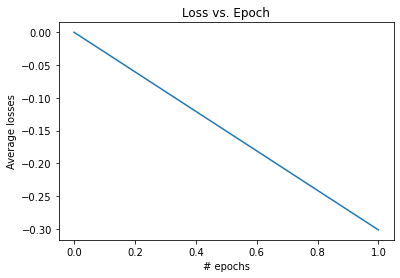

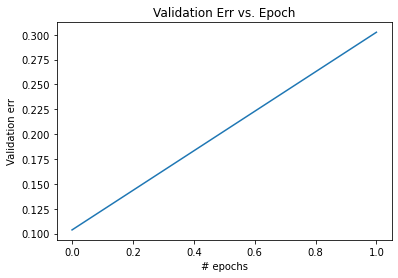

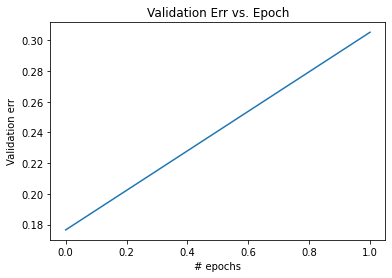

In [ ]:
print(f"average loss min = : {avg_loss_min:.3f}")
print(f"validation error min = : {validation_loss_min:.3f}")
print(f"validation error 2 min = : {validation_loss_2_min:.3f}")

# Plot loss graphs
%matplotlib inline
plt.plot(avg_losses)
plt.xlabel('# epochs')
plt.ylabel('Average losses')
plt.title('Loss vs. Epoch')
plt.show()


%matplotlib inline
plt.plot(validation_losses)
plt.xlabel('# epochs')
plt.ylabel('Validation err')
plt.title('Validation Err vs. Epoch')
plt.show()


%matplotlib inline
plt.plot(validation_2_losses)
plt.xlabel('# epochs')
plt.ylabel('Validation err')
plt.title('Validation Err vs. Epoch')
plt.show()